# Optimizer 및 Training (Expert)

공식 홈페이지에서 설명하는 Expert 버전

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets

In [2]:
input_shape = (28, 28, 1)
num_classes = 10

In [5]:
inputs = layers.Input(input_shape, dtype=tf.float64)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.5)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



## Preprocess

텐서플로우 공식홈페이지에서 말한 expert한 방법

In [28]:
mnist = tf.keras.datasets.mnist

# Load Data from MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Channel 추가
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Data Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0

* from_tensor_slices()
* shuffle()
* barch()

## tf.data

In [29]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(1000) # 1000 정도가 적당한 값이다.
train_ds = train_ds.batch(32)

test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(32)

## Visualize Data

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

train_ds.take()

In [31]:
train_ds.take(2)

<TakeDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float64, tf.uint8)>

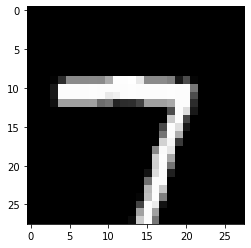

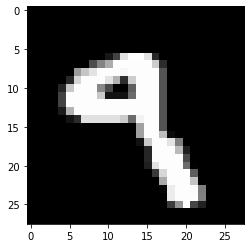

In [37]:
for image, label in train_ds.take(2):
#     plt.title(label[0])
    plt.imshow(image[0, :, :, 0], 'gray')
    plt.show()

## Training (Keras)

In [38]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(train_ds, epochs=10000)

Epoch 1/10000
   1465/Unknown - 77s 52ms/step - loss: 0.1811

KeyboardInterrupt: 

## Optimization
* Loss Function
* Optimizer

In [39]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

* Loss Function을 담을 곳
* Metrics

In [40]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


## Training
@tf.function - 기존 session 열었던 것 처럼 바로 작동하지 않고, 그래프만 만들고 학습이 시작되면 돌아가도록 함

In [53]:
@tf.function
def train_step(images, labels): 
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [54]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [55]:
for epoch in range(2):
    for images, labels in train_ds:
        train_step(images, labels)
        
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    template ='Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    
    print(template.format(epoch + 1,
                            train_loss.result(),
                            train_accuracy.result() * 100, 
                            test_loss.result(),
                            test_accuracy.result() * 100))

Epoch 1, Loss: 0.02927498333156109, Accuracy: 99.08333587646484, Test Loss: 0.04038609191775322, Test Accuracy: 98.86000061035156
Epoch 2, Loss: 0.02463826723396778, Accuracy: 99.21749877929688, Test Loss: 0.04512322321534157, Test Accuracy: 98.80500030517578


## Evaluating
* 학습한 모델 확인

model.evaluate